# 1. 손글씨 숫자 데이터셋 심화 실험 (실습 1)

다음 조건에 따라 손글씨 숫자 데이터셋 (sklearn.datasets.load_digits)을 활용해 실험을 수행하고 결과 분석   

> 실습 1 : 학습률 변화에 따른 정확도 비교  
- Adam 옵티마이저를 사용하고, 학습률을 각각 아래에 세 가지로 설정해 모델을 학습
- 0.01, 0,001, 0.0001
- 각 학습률에 대해 최종 정확도를 비교하고, 학습 과정의 loss 또는 accuracy 변화 곡선을 시각화
- 학습률에 따라 정확도가 어떻게 달라지는지 분석

> 실습 2 : 훈련 데이터 축소 후 혼동 행렬 분석  
- train_test_split을 사용해 전체 데이터 중 훈련 데이터의 비율을 50%만 사용해 학습을 진행
- 학습된 모델에 대해 테스트 데이터에 대한 confusion matrix 를 출력하고 시각화
- 오분류된 숫자들이 어떤 것인지 확인하고 그 이유를 분석.


In [64]:
import numpy as np                         # 배열 연산
import matplotlib.pyplot as plt            # 그래프 그리기
import seaborn as sns                      # 고수준 시각화
from sklearn.datasets import load_digits   # 손글씨 숫자 데이터셋
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import torch                               # PyTorch 메인 패키지
import torch.nn as nn                      # 신경망 모듈
import torch.optim as optim                # 최적화 알고리즘
from torch.utils.data import TensorDataset, DataLoader


### 데이터 로드, 파이토치 데이터셋 준비


In [65]:
# 1) 사이킷런에서 데이터 로드
digits = load_digits()
X, y = digits.data.astype(np.float32), digits.target.astype(np.int64)
print(X.shape, y.shape)
# -> (1797, 64): 8x8 이미지 1,797개, 0~9 레이블

(1797, 64) (1797,)


In [66]:
# 2) NumPy 배열을 PyTorch Tensor로 변환
X_tensor = torch.from_numpy(X)  # (1797, 64), float32
y_tensor = torch.from_numpy(y)  # (1797,), int64

# 3) TensorDataset과 DataLoader 생성 (batch 처리 및 셔플 지원)
full_ds     = TensorDataset(X_tensor, y_tensor)
full_loader = DataLoader(full_ds, batch_size=64, shuffle=True)

In [67]:
# 4) 한 배치 확인
batch_X, batch_y = next(iter(full_loader))
print("배치 X.shape, y.shape:", batch_X.shape, batch_y.shape)
# -> (64, 64), (64,)

배치 X.shape, y.shape: torch.Size([64, 64]) torch.Size([64])


### MLP 모델 정의


In [68]:
class DigitNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Sequential: 레이어를 순서대로 묶어주는 컨테이너
        self.net = nn.Sequential(
            nn.Linear(64, 128),   # 입력(64) → 은닉(128)
            nn.ReLU(),            # 활성화 함수
            nn.Linear(128, 64),   # 은닉(128) → 은닉(64)
            nn.ReLU(),            # 활성화
            nn.Linear(64, 10)     # 은닉(64) → 출력(10)
            # 소프트맥스는 CrossEntropyLoss 내부에서 계산됨
        )
    def forward(self, x):
        return self.net(x)

### 훈련/검증 루프 함수 정의

In [69]:
def train_epoch(model, loader, criterion, optimizer, device):
    """한 epoch 동안 학습 실행 후 평균 loss, accuracy 반환"""
    model.train()  # 학습 모드 전환 (Dropout, BatchNorm 등 활성화)
    total_loss, total_acc = 0.0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)      # GPU/CPU 장치로 이동
        optimizer.zero_grad()                       # 기울기 초기화
        logits = model(xb)                          # 순전파
        loss   = criterion(logits, yb)              # 손실 계산
        loss.backward()                             # 역전파
        optimizer.step()                            # 가중치 갱신

        total_loss += loss.item() * xb.size(0)      # 배치 손실 합산
        total_acc  += (logits.argmax(1) == yb).sum().item()  # 맞춘 개수
    n = len(loader.dataset)
    return total_loss / n, total_acc / n

def eval_epoch(model, loader, criterion, device):
    """한 epoch 동안 검증(평가) 실행 후 평균 loss, accuracy 반환"""
    model.eval()  # 평가 모드 전환 (Dropout, BatchNorm 동결)
    total_loss, total_acc = 0.0, 0
    with torch.no_grad():  # 기울기 계산 비활성화
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss   = criterion(logits, yb)
            total_loss += loss.item() * xb.size(0)
            total_acc  += (logits.argmax(1) == yb).sum().item()
    n = len(loader.dataset)
    return total_loss / n, total_acc / n


### 실습 1 : 학습률 변화에 따른 정확도 비교

In [70]:
# 5-1) 데이터 분할 (80% 학습, 20% 검증)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=2025, stratify=y
)
train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_ds   = TensorDataset(torch.from_numpy(X_val),   torch.from_numpy(y_val))
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=False)

# 5-2) 실험할 학습률 목록과 기본 설정
device   = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lrs      = [1e-2, 1e-3, 1e-4]
criterion = nn.CrossEntropyLoss()  # 소프트맥스 + 크로스엔트로피
epochs    = 100

history = {}  # 학습률별 기록 저장용

# 5-3) 학습 루프
for lr in lrs:
    model     = DigitNet().to(device)                          # 모델 초기화
    optimizer = optim.Adam(model.parameters(), lr=lr)          # Adam 옵티마이저 생성

    history[lr] = {'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss':   []}

    for epoch in range(1, epochs+1):
        # train_epoch는 (model, loader, criterion, optimizer, device)
        tr_loss, tr_acc = train_epoch(model, train_loader, criterion, optimizer, device)

        # eval_epoch는 (model, loader, criterion, device) → optimizer 인자 제거!!
        va_loss, va_acc = eval_epoch(model, val_loader, criterion, device)

        history[lr]['train_acc'].append(tr_acc)
        history[lr]['val_acc'].append(va_acc)
        history[lr]['train_loss'].append(tr_loss)
        history[lr]['val_loss'].append(va_loss)

    print(f"[lr={lr:.4f} | Epoch {epoch:2d}] "
          f"Train Loss: {tr_loss:.4f}, Acc: {tr_acc:.4f} | "
          f"Val Loss: {va_loss:.4f}, Acc: {va_acc:.4f}")


[lr=0.0100 | Epoch 100] Train Loss: 0.0000, Acc: 1.0000 | Val Loss: 0.0886, Acc: 0.9833
[lr=0.0010 | Epoch 100] Train Loss: 0.0002, Acc: 1.0000 | Val Loss: 0.0592, Acc: 0.9861
[lr=0.0001 | Epoch 100] Train Loss: 0.0201, Acc: 0.9979 | Val Loss: 0.0737, Acc: 0.9806


- Train Loss : 학습 데이터에서의 손실값 (모델이 학습데이터에 얼마나 잘 맞는지)
- Train Acc : 학습 데이터에서의 정확도
(학습 데이터 예측 정확도)
- Val Loss : 검증 데이터에서의 손실값
(모델이 새로운 데이터에 얼마나 잘 작동하는지)
- Val acc : 검증 데이터에서의 정확도 (검증 데이터 예측 정확도)

### 학습곡선 시각화 _ 정확도

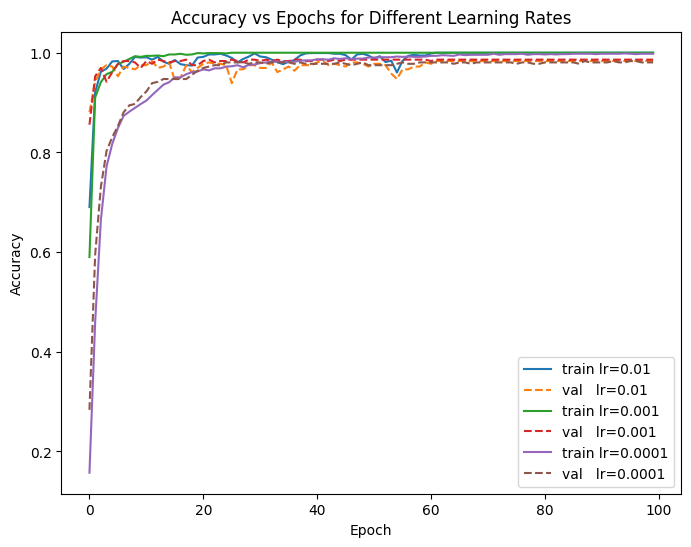

In [71]:
plt.figure(figsize=(8,6))
for lr in lrs:
    plt.plot(history[lr]['train_acc'], label=f"train lr={lr}")
    plt.plot(history[lr]['val_acc'],   '--', label=f"val   lr={lr}")
plt.title("Accuracy vs Epochs for Different Learning Rates")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


### 학습 곡선 시각화 _ 손실률

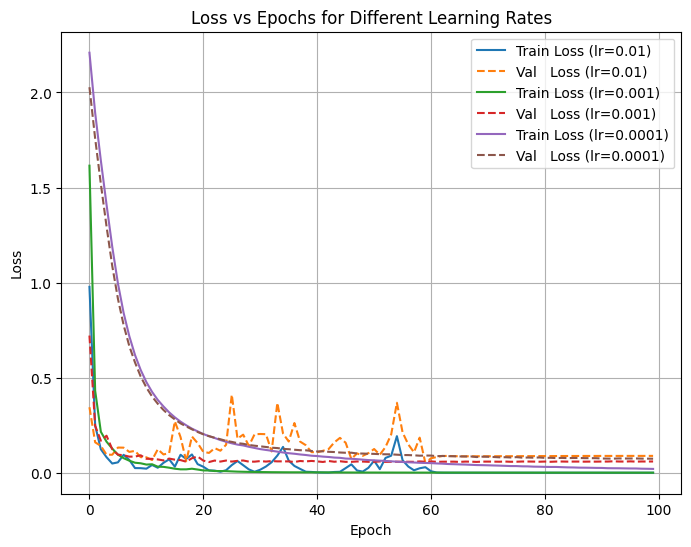

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))  # 그래프 크기 설정

for lr in lrs:
    # 학습 손실 (실선)
    plt.plot(
        history[lr]['train_loss'],
        label=f"Train Loss (lr={lr})"
    )
    # 검증 손실 (점선)
    plt.plot(
        history[lr]['val_loss'],
        linestyle='--',
        label=f"Val   Loss (lr={lr})"
    )

plt.title("Loss vs Epochs for Different Learning Rates")  # 제목
plt.xlabel("Epoch")                                       # x축 라벨
plt.ylabel("Loss")                                        # y축 라벨
plt.legend()                                              # 범례 표시
plt.grid(True)                                            # 격자선 표시
plt.show()                                                # 그래프 출력


# 학습률에 따른 정확도 분석

1. 0.01
- 빠른 수렴 : 초반 몇 Epoch만에 train_loss가 0에 수렴, train_acc 100% 달성
- 진동 & 과적합 징후 : val 곡선, 특히 loss가 중 후반에 진동이 큼. 최종 val_acc도 98.33%로 중간값   
> 특성
> - 매우 빠르게 손실을 줄이고 정확도를 끌어올림
> - val에서 진동 발생 -> 장기 학습 시 안정성 저하 우려 있음

2. 0.001
- 안정적 수렴 : train/val 곡선 모두 급격히 올라간 뒤 안정적으로 플래토 형성
- 최고 성능 : 최종 val acc 98.61%, val loss 0.0592로 가장 낮음. -> 가장 좋은 일반화 성능
> 특성
> - 속도 + 안정성의 균형이 가장 좋음
> - 짧은 Epoch에서도 충분히 수렴하면서 과적합 없이 높은 일반화 성능 달성함

3. 0.0001
- 느린 수렴 : 100 Epoch까지도 train loss가 0.02 정도 남아있고, train acc는 99.79%
- 과소적합 경향 : val acc 는 98.06%로 가장 낮고, 곡선도 완만하게 오르는 형태
> 특성
> - 안정적인 감소 궤적
> - 매우 느려서 같은 epoch 수 내 충분히 수렴하지 못함   


### 결론

* 학습률에 따라 정확도가 달라지는 방식
1. 너무 크면 빠르게 수렴하지만 val 성능이 불안정
2. 적절히 중간이면 수렴 속도와 안정성 모두 우수
3. 너무 작으면 학습이 느려 충분한 epoch 필요


# 고민 & 질문

1. 학습률을 바꿔가며 학습해보는 게 필요한가?
- 학습률은 모델이 손실 함수의 최저점을 향해 얼마나 크게 이동할지를 결정하기 때문에, 너무 크면 발산+진동, 너무 작으면 느린 수렴이나 국소 최저점 갇힘 현상이 생김
- 따라서 grid search나 learning-rate finder를 써서 여러 값을 시험해보고, 최종 검증 정확도가 좋은 값을 선택해보는 것이 좋을 것 같다.   

2. 학습 중에 자동으로 학습을 낮춰주는 도구는 없을까?
- ReduceLROnPlateau, StepLR같은 스케줄러 도구가 있음. 학습 중에 자동으로 학습을 낮춰줘 "초반엔 크게(빠르게 수렴하기 위함), 후반엔 작게" 이동시킬 수도 있음

3. 0.0001 같은 작은 학습률에서는 epoch를 늘리면 정확도가 진짜 올라갈까?
- 이론적(일반적)으로는 한 epoch당 손실 감소량이 작아서, 충분히 많은 epoch을 돌리면 계속 학습이 진행되고 검증 정확도도 조금씩 개선될 가능성이 높지만 주의해야할 점

(1) 개선 폭이 점점 줄어드는 수렴 구간에 접어들면   
(2) 계산 비용 대비 성능 향상이 미미해질 수 있고  
(3) 오히려 너무 오래 학습하면 과적합이 시작될 수 있음   
=> 실제로 epoch를 늘려보고 val acc가 여전히 상승하는지, val loss가 플래토 혹은 상승 전환 되는지를 관찰하면 된다.

[Epoch 50] Val Acc: 0.9722, Val Loss: 0.0983
[Epoch 100] Val Acc: 0.9861, Val Loss: 0.0662
[Epoch 150] Val Acc: 0.9861, Val Loss: 0.0604
[Epoch 200] Val Acc: 0.9861, Val Loss: 0.0608


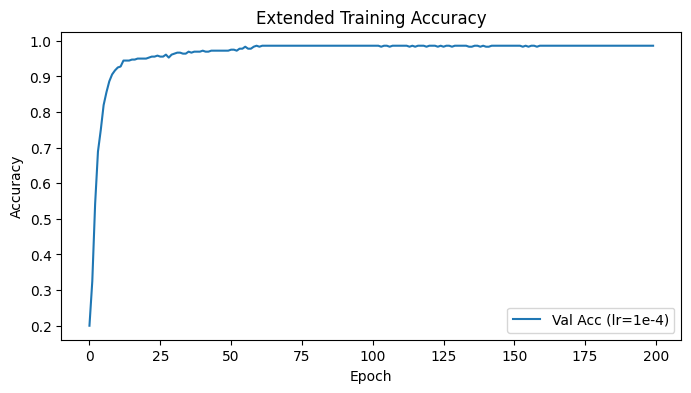

In [73]:
extended_lr = 1e-4
extended_epochs = 200

# 모델·옵티마이저 초기화
ext_model     = DigitNet().to(device)
ext_optimizer = optim.Adam(ext_model.parameters(), lr=extended_lr)

# 기록용
ext_hist = {'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss': []}

for epoch in range(1, extended_epochs+1):
    tr_loss, tr_acc = train_epoch(ext_model, train_loader, criterion, ext_optimizer, device)
    va_loss, va_acc = eval_epoch(ext_model, val_loader,   criterion, device)

    ext_hist['train_loss'].append(tr_loss)
    ext_hist['val_loss'].append(va_loss)
    ext_hist['train_acc'].append(tr_acc)
    ext_hist['val_acc'].append(va_acc)

    # 중간 진행 상황 출력
    if epoch % 50 == 0:
        print(f"[Epoch {epoch}] Val Acc: {va_acc:.4f}, Val Loss: {va_loss:.4f}")

# 시각화 (epoch 1~200)
plt.figure(figsize=(8,4))
plt.plot(ext_hist['val_acc'], label='Val Acc (lr=1e-4)')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.title('Extended Training Accuracy')
plt.legend(); plt.show()

### 3번에 대한 검증 결과
epoch를 200으로 늘려고 val acc가 0.9861에 머무르고, val loss도 0.06 부근에서 더 내려가지 않는 걸 볼 수 있다. (일종의 수렴 : 플래토)에 도달한 것

### 왜 더 돌려도 좋아지지 않을까?
- 학습률이 너무 낮을수도 있음
- 모델 용량 한계 : 간단한 MLP 구조가 이미 데이터 패턴을 충분히 학습해서 더 복잡한 표현이 필요 없거나, 잡아내기 힘들 수 있음
- 데이터 한계 : 이미 정보가 한계에 달해 이 이상 일반화 성능을 끌어올릴 여지가 적을 수 있음
